In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/book-recommendation-dataset/Ratings.csv
/kaggle/input/book-recommendation-dataset/Users.csv
/kaggle/input/book-recommendation-dataset/Books.csv


In [2]:
df1 = pd.read_csv('/kaggle/input/book-recommendation-dataset/Ratings.csv', low_memory=False)
df2 = pd.read_csv('/kaggle/input/book-recommendation-dataset/Users.csv', low_memory=False)
df3 = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv', low_memory=False)

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [6]:
# remove 'DK Publishing Inc', 'Gallimard' values from 'Year-Of-Publication' column and convert to int
df3 = df3[~df3['Year-Of-Publication'].isin(['DK Publishing Inc', 'Gallimard'])]
df3['Year-Of-Publication'] = pd.to_numeric(df3['Year-Of-Publication'])

* Dataset 1 - Rating.csv (11149780)
    * User-ID - user ID
    * ISBN - book ID
    * Book-Rating - Rating given by user
    
* Dataset 2 - Users.csv (278858)
    * User-ID - user ID
    * Location - location of user
    * Age - age of user

* Dataset 3 - Books.csv (271360)
    * ISBN - book ID
    * Book-Title - Book Name
    * Book-Author
    * Year-Of-Publication
    * Publisher
    * Image-URL-S
    * Image-URL-M
    * Image-URL-L

# EDA

In [7]:
def plot_distribution(feature, data):
    sns.displot(x=feature, data=data, kde=True, color='#244747');
    plt.figtext(0.2, 1, '%s Distribution'%feature, fontfamily='serif', fontsize=17, fontweight='bold');

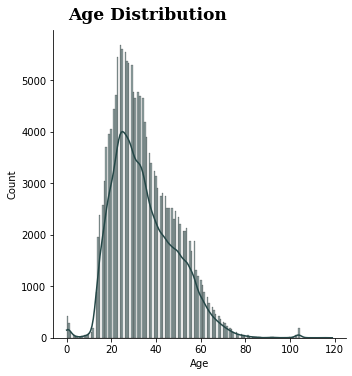

In [8]:
df2 = df2[df2['Age']<=120]
# Distribution of user as per age
plot_distribution('Age', df2)

remove users with age above 120

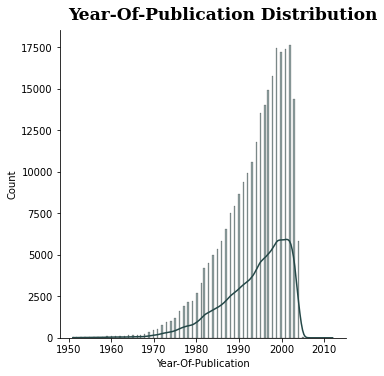

In [9]:
df3 = df3[(df3['Year-Of-Publication']>1950) & (df3['Year-Of-Publication']<=2016)]
# Distribution across year of publication
plot_distribution('Year-Of-Publication', df3)

remove books before 1950 as there are not many and before 2016

# Recommendor 1 : Demographic Filtering

## 1. Top 20 Highest Rated Books

In [10]:
data = df1.groupby('ISBN').agg(['mean', 'count'])['Book-Rating'].reset_index()

# generate score based on mean rating and total number of times the book is rated
m = data['count'].quantile(0.99) # minimum votes required to be listed in the Top 250
data = data[data['count']>m]
print('m =', m)
print(data.shape)
R = data['mean'] # average for the book (mean) = (Rating)
v = data['count'] # number of votes for the book = (votes)
C = data['mean'].mean() # mean vote across all books
data['weighted rating'] = (v/(v+m))*R + (m/(v+m))*C
data = data.sort_values('weighted rating', ascending=False).reset_index(drop=True)

# get title of books
data = pd.merge(data, df3, on='ISBN')[['Book-Title', 'Book-Author', 'mean', 'count', 'weighted rating', 
                              'Year-Of-Publication']].drop_duplicates('Book-Title').iloc[:20]
data

m = 36.0
(3306, 3)


,Book-Title,Book-Author,mean,count,weighted rating,Year-Of-Publication
0,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,6.541237,194,5.985285,2000
1,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,6.611765,170,5.978717,1999
2,Free,Paul Vincent,7.962963,54,5.973507,2003
3,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,6.467005,197,5.929681,1999
4,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,6.363095,168,5.767724,1998
5,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,5.571856,334,5.320583,2003
6,The Fellowship of the Ring (The Lord of the Ri...,J. R. R. Tolkien,6.206349,63,5.036522,1999
7,Griffin &amp; Sabine: An Extraordinary Corresp...,Nick Bantock,6.041667,72,5.024219,1991
9,Falling Up,Shel Silverstein,6.921053,38,5.008320,1996
10,The Stand (The Complete and Uncut Edition),Stephen King,6.175439,57,4.942104,1990


## 2. Top 20 Highest Rated Authors

In [11]:
# drop any duplicates in df3
df3 = df3.drop_duplicates(['Book-Author', 'Book-Title'])

# get book-author and title from df3
data = pd.merge(df3, df1, on='ISBN')[['Book-Author', 'Book-Rating', 'Book-Title', 'ISBN']]

data = data.groupby('Book-Author').agg(['mean', 'count'])['Book-Rating'].reset_index()

# generate score based on mean rating and total number of times the author is rated
m = data['count'].quantile(0.99) # minimum votes required to be listed in the Top 250
data = data[data['count']>m]
print('m =', m)
print(data.shape)
R = data['mean'] # average for the author (mean) = (Rating)
v = data['count'] # number of votes for the author = (votes)
C = data['mean'].mean() # mean vote across all authors
data['weighted rating'] = (v/(v+m))*R + (m/(v+m))*C
data = data.sort_values('weighted rating', ascending=False).reset_index(drop=True)

data.iloc[:20]

m = 130.0
(996, 3)


,Book-Author,mean,count,weighted rating
0,J. K. Rowling,5.411434,2134,5.263202
1,Bill Watterson,5.498134,536,4.977312
2,J. R. R. Tolkien,5.265861,662,4.866023
3,Shel Silverstein,6.273333,150,4.674607
4,Dr. Seuss,5.168044,363,4.551501
5,Nick Bantock,5.278810,269,4.480927
6,Harper Lee,4.932039,412,4.427841
7,J.R.R. TOLKIEN,4.511224,980,4.314315
8,Neil Gaiman,4.453074,1236,4.298602
9,Daniel Quinn,5.012295,244,4.253716


# Recommender 2: Collaborative Filtering
Based on records from various users provide recommendations based on user similarities

In [12]:
# merge df1 and df5 to get movie titles and drop rows for which title is not available
data = pd.merge(df1, df3, on='ISBN')

# get total counts of no. of occurence of book
data['count'] = data.groupby('ISBN').transform('count')['User-ID']

# fetch top 100 books based on count
isbn = data.drop_duplicates('ISBN').sort_values(
    'count', ascending=False).iloc[:100]['ISBN']

# filter out data as per the ISBN
data = data[data['ISBN'].isin(isbn)].reset_index(drop=True)

In [13]:
# create a user book rating matrix
df = data.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
df.head()

ISBN,0060392452,0060502258,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060987103,0061009059,...,0743237188,0743418174,0786868716,080410526X,0804106304,0805063897,0842329129,0971880107,1400034779,1558743669
User-ID,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# get user-ID for users who have read more than 50 books
temp = df[~df.isna()].count(axis=1).reset_index()
temp[temp[0]>50]

,User-ID,0
629,11676,100
912,16795,70
1158,21014,54
1323,23768,54
2131,35859,69
2647,43246,54
3682,60244,53
4628,76352,54
4769,78783,51
6170,102967,54


## 1. Using Surpise Library

In [15]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import train_test_split, cross_validate

In [16]:
reader = Reader(rating_scale=(0, 10))
surprise_data = Dataset.load_from_df(data[['User-ID', 'ISBN', 'Book-Rating']], reader)
trainset, testset = train_test_split(surprise_data, test_size=0.25)

In [17]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD()]:
    # Perform cross validation
    results = cross_validate(algorithm, surprise_data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,3.906093,2.848762,0.146185


In [18]:
svd = SVD() 
svd.fit(trainset)

In [19]:
index_val = 2131
# get user id
userId = df.index[index_val]
books = []
ratings = []
titles = []

for isbn in df.iloc[index_val][df.iloc[index_val].isna()].index:
    books.append(isbn)
    title = data[data['ISBN']==isbn]['Book-Title'].values[0]
    titles.append(title)
    ratings.append(svd.predict(userId, isbn).est)

prediction = pd.DataFrame({'ISBN':books, 'title':titles, 'rating':ratings, 'userId':userId})  
prediction = prediction.sort_values('rating', ascending=False).iloc[:10].reset_index(drop=True)

# get other high rated books by user
temp = data[data['User-ID']==df.index[index_val]].sort_values(
    'Book-Rating', ascending=False)[['Book-Rating', 'Book-Title', 'User-ID']].iloc[:10].reset_index(drop=True)
prediction['Book Read'] = temp['Book-Title']
prediction['Rated']= temp['Book-Rating']
prediction

,ISBN,title,rating,userId,Book Read,Rated
0,0140293248,The Girls' Guide to Hunting and Fishing,5.665600,35859,Fahrenheit 451,10
1,0446612545,The Beach House,4.906809,35859,Harry Potter and the Sorcerer's Stone (Harry P...,10
2,0060959037,Prodigal Summer: A Novel,4.630792,35859,One for the Money (Stephanie Plum Novels (Pape...,10
3,0440206154,Red Dragon,4.475506,35859,The Red Tent (Bestselling Backlist),10
4,0345339703,The Fellowship of the Ring (The Lord of the Ri...,3.652609,35859,Bel Canto: A Novel,9
5,0060987103,Wicked: The Life and Times of the Wicked Witch...,3.483041,35859,The Secret Life of Bees,9
6,0316769487,The Catcher in the Rye,3.086998,35859,Left Behind: A Novel of the Earth's Last Days ...,9
7,0440222656,The Horse Whisperer,2.994207,35859,The Joy Luck Club,8
8,0515131229,Dance upon the Air (Three Sisters Island Trilogy),2.963652,35859,Two for the Dough,8
9,0316284955,White Oleander : A Novel (Oprah's Book Club),2.868035,35859,Balzac and the Little Chinese Seamstress : A N...,8


In [20]:
index_val = 912
# get user id
userId = df.index[index_val]
books = []
ratings = []
titles = []

for isbn in df.iloc[index_val][df.iloc[index_val].isna()].index:
    books.append(isbn)
    title = data[data['ISBN']==isbn]['Book-Title'].values[0]
    titles.append(title)
    ratings.append(svd.predict(userId, isbn).est)

prediction = pd.DataFrame({'ISBN':books, 'title':titles, 'rating':ratings, 'userId':userId})  
prediction = prediction.sort_values('rating', ascending=False).iloc[:10].reset_index(drop=True)

# get other high rated books by user
temp = data[data['User-ID']==df.index[index_val]].sort_values(
    'Book-Rating', ascending=False)[['Book-Rating', 'Book-Title', 'User-ID']].iloc[:10].reset_index(drop=True)
prediction['Book Read'] = temp['Book-Title']
prediction['Rated']= temp['Book-Rating']
prediction

,ISBN,title,rating,userId,Book Read,Rated
0,0446310786,To Kill a Mockingbird,10.000000,16795,"A Child Called \It\"": One Child's Courage to S...",10
1,0671003755,She's Come Undone (Oprah's Book Club (Paperback)),8.695253,16795,The Da Vinci Code,10
2,0316284955,White Oleander : A Novel (Oprah's Book Club),8.079633,16795,The Lovely Bones: A Novel,10
3,043935806X,Harry Potter and the Order of the Phoenix (Boo...,7.495306,16795,The Secret Life of Bees,10
4,0805063897,Nickel and Dimed: On (Not) Getting By in America,6.159421,16795,She's Come Undone (Oprah's Book Club),10
5,0060938455,Fast Food Nation: The Dark Side of the All-Ame...,6.050249,16795,The Notebook,10
6,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,5.918016,16795,House of Sand and Fog,9
7,0375700757,Cold Mountain : A Novel,5.902377,16795,The Red Tent (Bestselling Backlist),9
8,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,5.806213,16795,The Horse Whisperer,9
9,0380731851,Mystic River,5.725593,16795,The Bridges of Madison County,9


## 2. Using mean of other user' weighted ratings based on similarity matrix
Here assumed rating may not make much sense as most of the books are not read by other users

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

In [22]:
# replace NaN with user based average rating in pivot dataframe
df_imputed = df.fillna(df.mean(axis=0))

# get similarity between all users
similarity_matrix = cosine_similarity(df_imputed.values)

In [23]:
def get_recommendation(user_index):
    idx = user_index
    sim_scores = list(enumerate(similarity_matrix[idx]))

    # get books that are unrated by the given user
    unrated_books = df.iloc[idx][df.iloc[idx].isna()].index

    # get weighted ratings of unrated books by all other users
    book_ratings = (df[unrated_books].T * similarity_matrix[idx]).T

    # get top 100 similar users by skipping the current user
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:101]

    # get mean of book ratings by top 100 most similar users for the unrated books
    book_ratings = book_ratings.iloc[[x[0] for x in sim_scores]].mean()
    
    # get rid of null values and sort it based on ratings
    book_ratings = book_ratings.reset_index().dropna().sort_values(0, ascending=False).iloc[:10]
    
    # get recommended book titles in sorted order
    recommended_books = data[data['ISBN'].isin(book_ratings['ISBN'])][['ISBN', 'Book-Title']]
    recommended_books = recommended_books.drop_duplicates('ISBN').reset_index(drop=True)
    assumed_ratings = book_ratings[0].reset_index(drop=True)

    return pd.DataFrame({'ISBN':recommended_books['ISBN'], 
                         'Recommended Book':recommended_books['Book-Title'], 
                         'Assumed Rating':assumed_ratings})

In [24]:
user_index = 2131
recommended_books = get_recommendation(user_index)
# get other high rated books by user
temp = data[data['User-ID']==df.index[user_index]].sort_values(
    'Book-Rating', ascending=False)[['Book-Rating', 'Book-Title', 'User-ID']].iloc[:10].reset_index(drop=True)
recommended_books['userId'] = temp['User-ID']
recommended_books['Book Read'] = temp['Book-Title']
recommended_books['Rated']= temp['Book-Rating']
recommended_books

,ISBN,Recommended Book,Assumed Rating,userId,Book Read,Rated
0,0684872153,Angela's Ashes (MMP) : A Memoir,7.089074,35859,Fahrenheit 451,10
1,0316284955,White Oleander : A Novel (Oprah's Book Club),6.819865,35859,Harry Potter and the Sorcerer's Stone (Harry P...,10
2,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,6.214522,35859,One for the Money (Stephanie Plum Novels (Pape...,10
3,0345361792,A Prayer for Owen Meany,6.166465,35859,The Red Tent (Bestselling Backlist),10
4,0786868716,The Five People You Meet in Heaven,6.130962,35859,Bel Canto: A Novel,9
5,080410526X,All I Really Need to Know,5.704645,35859,The Secret Life of Bees,9
6,0440222656,The Horse Whisperer,5.626918,35859,Left Behind: A Novel of the Earth's Last Days ...,9
7,0316769487,The Catcher in the Rye,4.815939,35859,The Joy Luck Club,8
8,0345339703,The Fellowship of the Ring (The Lord of the Ri...,4.115793,35859,Two for the Dough,8
9,0060959037,Prodigal Summer: A Novel,4.087308,35859,Balzac and the Little Chinese Seamstress : A N...,8


In [25]:
user_index = 6349
recommended_books = get_recommendation(user_index)
# get other high rated books by user
temp = data[data['User-ID']==df.index[user_index]].sort_values(
    'Book-Rating', ascending=False)[['Book-Rating', 'Book-Title', 'User-ID']].iloc[:10].reset_index(drop=True)
recommended_books['userId'] = temp['User-ID']
recommended_books['Book Read'] = temp['Book-Title']
recommended_books['Rated']= temp['Book-Rating']
recommended_books

,ISBN,Recommended Book,Assumed Rating,userId,Book Read,Rated
0,0671510053,SHIPPING NEWS,7.467531,106225,Girl with a Pearl Earring,10
1,1558743669,"A Child Called \It\"": One Child's Courage to S...",7.000075,106225,Angela's Ashes (MMP) : A Memoir,9
2,0060930535,The Poisonwood Bible: A Novel,6.980253,106225,"Tuesdays with Morrie: An Old Man, a Young Man,...",9
3,0345339681,The Hobbit : The Enchanting Prelude to The Lor...,6.980253,106225,A Painted House,9
4,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,6.980202,106225,The Lovely Bones: A Novel,8
5,0345378490,Congo,6.967019,106225,Good in Bed,8
6,0375727345,House of Sand and Fog,6.927949,106225,White Oleander : A Novel (Oprah's Book Club),8
7,0345339703,The Fellowship of the Ring (The Lord of the Ri...,6.609094,106225,The Secret Life of Bees,8
8,0060959037,Prodigal Summer: A Novel,6.382191,106225,The Brethren,6
9,0375700757,Cold Mountain : A Novel,6.223824,106225,The Handmaid's Tale,0
